# Tarea 2: Minería de Texto básica
## Alan García Zermeño
### CIMAT, 13/02/2022


Para la realización de esta tarea, reusaremos el código realizado para la práctica 3 de la bolsa de palabras.


---



In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer
import numpy as np

In [2]:
def get_text_from_file(path_corpus, path_truth):
  tr_txt = []
  tr_y = []

  with open(path_corpus,"r") as f_corpus, open(path_truth, "r") as f_truth:
    for twitt in f_corpus:
      tr_txt += [twitt]
    for label in f_truth:
      tr_y += [label]
  
  return tr_txt,tr_y

In [3]:
tr_txt, tr_y = get_text_from_file("/content/drive/MyDrive/Colab Notebooks/mex_data/mex_train.txt","/content/drive/MyDrive/Colab Notebooks/mex_data/mex_train_labels.txt")

Counter({'0\n': 3563, '1\n': 1981})


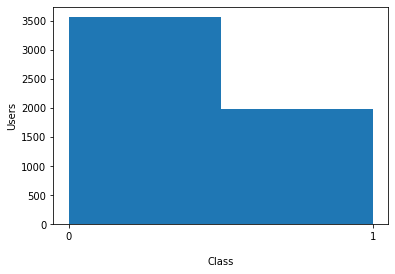

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins = len(set(tr_y)))

plt.ylabel('Users');
plt.xlabel('Class');

## Construcción de los datos

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [6]:
import nltk
#nltk.download('stopwords')
#stopwords = nltk.corpus.stopwords.words('spanish')

corpus_palabras = []
for doc in tr_txt:
  corpus_palabras += tokenizer.tokenize(doc)

#corpus_palabras = [t for t in corpus_palabras if t not in stopwords]
fdist = nltk.FreqDist(corpus_palabras)

In [7]:
def sortFreqDist(freqdict):
  aux = [(freqdict[key],key) for key in freqdict]
  aux.sort()
  aux.reverse()
  return aux

In [8]:
V = sortFreqDist(fdist)
V = V[:5000]

In [9]:
dict_indices = dict()
cont = 0
for weight, word in V:
  dict_indices[word] = cont
  cont += 1

Counter({0: 397, 1: 219})


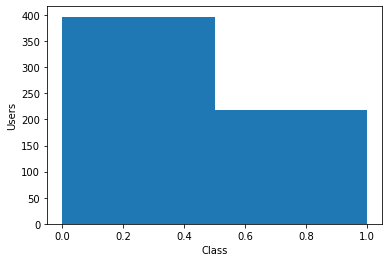

In [10]:
val_txt, val_y = get_text_from_file("/content/drive/MyDrive/Colab Notebooks/mex_data/mex_val.txt","/content/drive/MyDrive/Colab Notebooks/mex_data/mex_val_labels.txt")
val_y = list(map(int, val_y))

print(Counter(val_y))
plt.hist(val_y, bins = len(set(val_y)))

plt.ylabel('Users');
plt.xlabel('Class');


In [11]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score



---


## **1)** Evalar Bow con pesado binario.

$w_{i,j} = 1$    si el documento $d_i$ contiene un término $t_j$, de otra forma, vale cero.

In [ ]:
def build_bow_tr(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = 1
    
    cont_doc+=1
  
  return BOW

In [ ]:
BOW_tr = build_bow_tr(tr_txt, V, dict_indices)
BOW_val = build_bow_tr(val_txt, V, dict_indices)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[329  68]
 [ 47 172]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       397
           1       0.72      0.79      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.81      0.82       616



## **2)** Evaluar Bow con pesado de frecuencia.

$w_{i,j} =$    número de ocurrencias de $t_j$ en $d_i$

In [ ]:
def build_bow_trf(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
    
    cont_doc+=1
  
  return BOW

In [ ]:
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[334  63]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       397
           1       0.73      0.78      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.82      0.82       616



## **3)** Evaluar Bow con pesado *tfidf*

$w_{i,j} = \text{tf}(t_j,d_i) \times \text{idf}(t_j)$ , donde:

- tf($t_j,d_i)$ indica las ocurrencias de $t_j$ en el documento $d_i$
- $\text{idf}(t_j) = \log [N/\text{df}(t_j)]$, donde df$(t_j)$ es el número de documentos que contienen el término $t_j$, y N es el número de documentos totales.

In [ ]:
def build_bow_tfidf(tr_txt,V,dict_indices):
  N = len(tr_txt)
  BOW = np.zeros((N,len(V)),dtype = float)
  df_aux = np.zeros(len(V), dtype = int)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
        df_aux[dict_indices[word]] += 1
    
    cont_doc+=1
  
  for i in range(N):
    for j in range(len(V)):
      if df_aux[j] != 0:
        BOW[i, j] = BOW[i, j]*np.log(N/df_aux[j])
  
  return BOW

In [ ]:
BOW_tr = build_bow_tfidf(tr_txt, V, dict_indices)
BOW_val = build_bow_tfidf(val_txt, V, dict_indices)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[319  78]
 [ 77 142]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       397
           1       0.65      0.65      0.65       219

    accuracy                           0.75       616
   macro avg       0.73      0.73      0.73       616
weighted avg       0.75      0.75      0.75       616



## **4)** Evaluar BoW con pesado binario normalizado l2

Normalizamos ahora con la norma euclidiana la BoW obtenida con el pesado binario del ejercicio 1.

In [47]:
def normal2(BOW):
  for i in range(len(BOW)):
    norm = np.linalg.norm(BOW[i])
    for j in range(len(BOW[0])):
      if BOW[i,j] != 0:
        BOW[i,j] = BOW[i,j]/norm
  return(BOW)

BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[322  75]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       397
           1       0.69      0.78      0.73       219

    accuracy                           0.80       616
   macro avg       0.78      0.79      0.79       616
weighted avg       0.81      0.80      0.80       616



## **5)** Evaluar BoW con pesado frecuencia normalizado l2

Normalizamos ahora con la norma euclidiana la BoW obtenida con el pesado frecuencia del ejercicio 2.

In [ ]:
BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[321  76]
 [ 50 169]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       397
           1       0.69      0.77      0.73       219

    accuracy                           0.80       616
   macro avg       0.78      0.79      0.78       616
weighted avg       0.80      0.80      0.80       616



## **6)** Evaluar BoW con pesado tf-idf normalizado l2

Normalizamos ahora con la norma euclidiana la BoW obtenida con el pesado tf-idf del ejercicio 3.

In [ ]:
BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[317  80]
 [ 48 171]]
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       397
           1       0.68      0.78      0.73       219

    accuracy                           0.79       616
   macro avg       0.77      0.79      0.78       616
weighted avg       0.80      0.79      0.79       616



## **7)** Mostramos a continuación una tabla con los resultados previamente descritos.

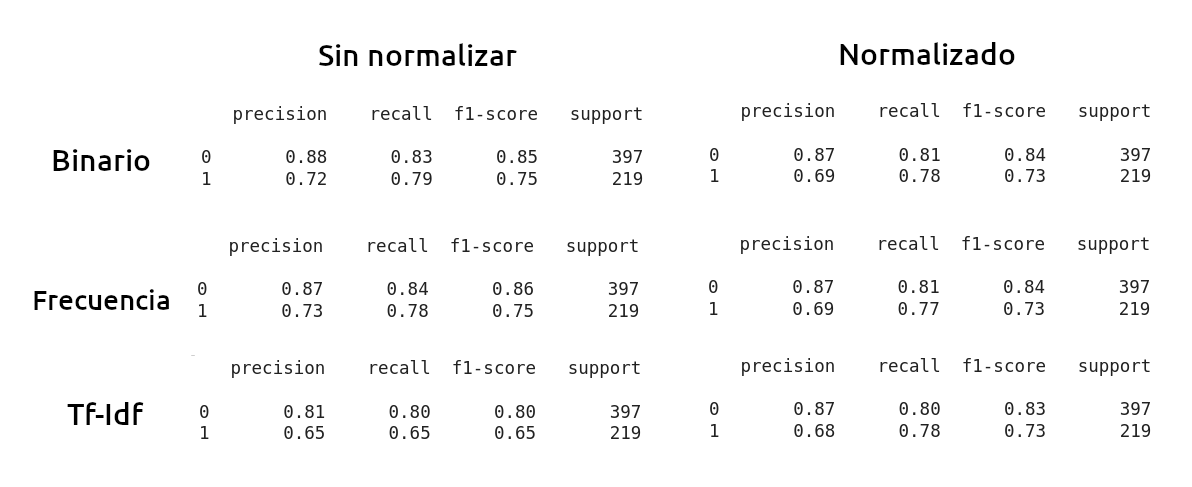

## **8)** Probamos ahora el pesado binario (la que mejor rendimiento ofreció) para probar con una BoW que contemple distintos tamaños de términos.

In [ ]:
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[334  63]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       397
           1       0.73      0.78      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.82      0.82       616



### A continuación mostramos los resultados obtenidos por pesado de frecuencia para una BoW de 500, 5000 y 7000 términos.

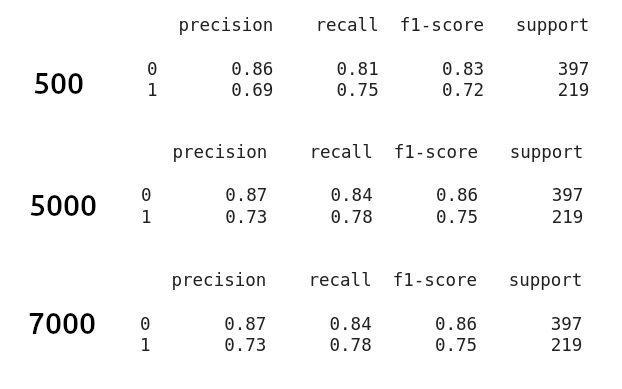

In [65]:
#@title .
incorrect = []
for e in zip(val_y,y_pred,range(len(val_y))):
  if e[0] != e[1]:
    incorrect += [e[2]]

In [ ]:
#@title .
for e in incorrect:
  case = e
  if "madre" in val_txt[case].strip():
    print("Texto: ", val_txt[case].strip())
    print("Truth: ", val_y[case])
    print("Pred: ", y_pred[case])

# **9)** Bolsa de emociones con EmoLex
Tomamos las palabras de EmoLex, cada una con categorías de emociones diferentes y hacemos una bolsa de emociones con las palabras de los tweets enmascaradas con las emociones del el recurso. 

In [ ]:
path_corpus = "/content/drive/MyDrive/Colab Notebooks/emociones/Spanish-NRC-EmoLex.txt"

emotions = {}
with open(path_corpus,"r") as f_corpus:#, open(path_truth, "r") as f_truth:
  gg = f_corpus.readline().split()
  del gg[:2]
  del gg[-2:]
  for line in f_corpus:
    t = line.split()
    n = " ".join(t[11:])
    t = t[1:10]
    emotions.update({n:[int(e) for e in t]})

print(gg)

['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']


In [ ]:
#Binario
def build_bow_tr(tr_txt,gg,emotions):
  BOW = np.zeros((len(tr_txt),len(gg)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions:
        t = emotions[word]
        for i in range(len(t)):
          if t[i] != 0:
            BOW[cont_doc,i] = 1
    
    cont_doc+=1
  
  return BOW

In [ ]:
#Frecuencia
def build_bow_trf(tr_txt,gg,emotions):
  BOW = np.zeros((len(tr_txt),len(gg)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions:
        t = emotions[word]
        for i in range(len(t)):
          if t[i] != 0:
            BOW[cont_doc,i] += 1
    
    cont_doc+=1
  
  return BOW

In [ ]:
#tf-idf
def build_bow_tfid(tr_txt,gg,emotions):
  BOW = np.zeros((len(tr_txt),len(gg)),dtype = float)
  df_aux = np.zeros(len(gg),dtype = int)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions:
        t = emotions[word]
        for i in range(len(t)):
          if t[i] != 0:
            BOW[cont_doc,i] += 1
        for j in range(len(t)):
          if BOW[cont_doc,j] != 0:
            df_aux+=1
    
    cont_doc+=1
  N = len(tr_txt)
  for i in range(N):
    for j in range(len(gg)):
      if df_aux[j] != 0:
        BOW[i, j] = BOW[i, j]*np.log(N/df_aux[j])
  
  return BOW

In [ ]:
BOW_tr = build_bow_tr(tr_txt, gg,emotions)
BOW_val = build_bow_tr(val_txt, gg,emotions)

In [ ]:
BOW_tr = build_bow_trf(tr_txt, gg,emotions)
BOW_val = build_bow_trf(val_txt, gg,emotions)

In [ ]:
BOW_tr = build_bow_tfid(tr_txt, gg,emotions)
BOW_val = build_bow_tfid(val_txt, gg,emotions)

In [ ]:
def normal2(BOW):
  for i in range(len(BOW)):
    norm = np.linalg.norm(BOW[i])
    if norm != 0:
      BOW[i] = BOW[i]/norm
  return(BOW)

In [ ]:
BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)

In [ ]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[190 207]
 [ 75 144]]
              precision    recall  f1-score   support

           0       0.72      0.48      0.57       397
           1       0.41      0.66      0.51       219

    accuracy                           0.54       616
   macro avg       0.56      0.57      0.54       616
weighted avg       0.61      0.54      0.55       616



## **10)** Después de realizar los tres pesados (normalizados) sobre la bolsa de emociones mostramos los resultados obtenidos. Vemos que en ninguno de los casos tenemos un clasificador decente con la estructura de la bolsa propuesta.

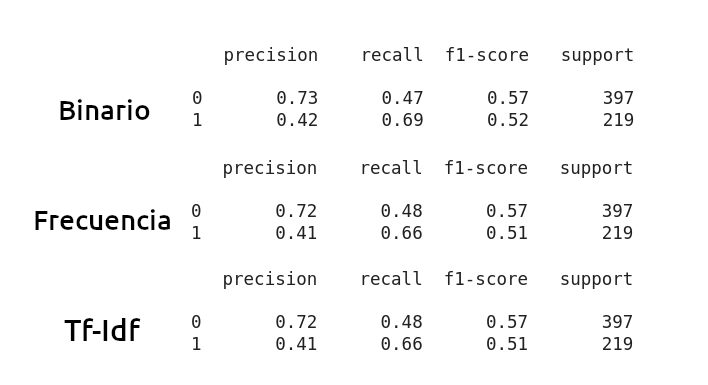



---


# **Recurso linguístico de Emociones Mexicano**
## **1.** Tomamos el recurso *Spanish Emotion Lexicon* (SEL) para la realización de otra bolsa de emociones.


In [54]:
path_corpus = "/content/drive/MyDrive/Colab Notebooks/emociones/SEL_full.txt"

emotions = {}
with open(path_corpus,"r",encoding='ISO-8859-1') as f_corpus:#, open(path_truth, "r") as f_truth:
  #gg = f_corpus.readline().split()
  #del gg[:2]
  #del gg[-2:]
  for line in f_corpus:
    t = line.split()
    emotions.update({t[0]:[t[6],float(t[5])]})


In [55]:
#Binario
def build_bow_tr(tr_txt,emotions):
  BOW = np.zeros((len(tr_txt),6),dtype = float)
  aux = {"Alegría":0, "Enojo":1, "Miedo":2, "Repulsión":3, "Sorpresa":4, "Tristeza":5}

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions.keys():
        t = emotions[word]
        BOW[cont_doc,aux[t[0]]] = 1
    cont_doc+=1
  
  return BOW

In [56]:
#Frecuencia
def build_bow_trf(tr_txt,emotions):
  BOW = np.zeros((len(tr_txt),6),dtype = float)
  aux = {"Alegría":0, "Enojo":1, "Miedo":2, "Repulsión":3, "Sorpresa":4, "Tristeza":5}

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions.keys():
        t = emotions[word]
        BOW[cont_doc,aux[t[0]]] += t[1]
    
    cont_doc+=1
  
  return BOW

In [57]:
#tf-idf
def build_bow_tfidf(tr_txt,emotions):
  BOW = np.zeros((len(tr_txt),6),dtype = float)
  aux = {"Alegría":0, "Enojo":1, "Miedo":2, "Repulsión":3, "Sorpresa":4, "Tristeza":5}
  df_aux = np.zeros(6,dtype = int)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions.keys():
        t = emotions[word]
        BOW[cont_doc,aux[t[0]]] += t[1]
    for j in range(6):
      if BOW[cont_doc,j] != 0:
        df_aux[j] += 1
    
    cont_doc+=1
  
  N = len(tr_txt)
  for i in range(N):
    for j in range(6):
      BOW[i,j] *= np.log(N/df_aux[j])
  return BOW

In [58]:
BOW_tr = build_bow_tr(tr_txt, emotions)
BOW_val = build_bow_tr(val_txt, emotions)

In [60]:
BOW_tr = build_bow_trf(tr_txt, emotions)
BOW_val = build_bow_trf(val_txt, emotions)

In [62]:
BOW_tr = build_bow_tfidf(tr_txt, emotions)
BOW_val = build_bow_tfidf(val_txt, emotions)

In [63]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[348  49]
 [174  45]]
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       397
           1       0.48      0.21      0.29       219

    accuracy                           0.64       616
   macro avg       0.57      0.54      0.52       616
weighted avg       0.60      0.64      0.59       616



## Resultados del los tres pesados en la bolsa de emociones SEL sin normalizar:
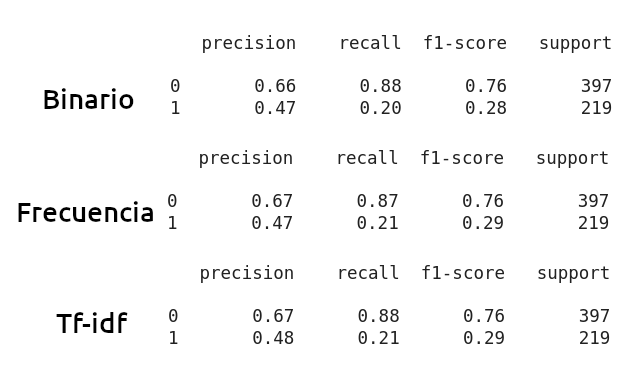

## **2)** El coeficiente PFA fue usado en el pesado de frecuencia y en el Tf-idf en el conteo de términos en el documento $d_i$. En vez de sumar un 1 a la emoción por cada término en el documento $d_i$ se sumó el correspondiente PFA del término.



---


# **Uso de bigramas**

## **1)** Podemos usar los 1000 bigramas más frecuentes para concatenar su BoB con la BoW con pesado de frecuencia para intentar conseguir un mejor modelo.

In [12]:
from nltk.text import Text
txtt = tokenizer.tokenize(". ".join(tr_txt).lower())
txtt = Text(txtt)

In [13]:
from nltk.collocations import *
bigram = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(txtt)
bigramas = finder.nbest(bigram.raw_freq, 1000)
bigramas[:15]

[('!', '!'),
 ('.', '@usuario'),
 ('la', 'verga'),
 ('a', 'la'),
 ('!', '.'),
 ('de', 'la'),
 ('@usuario', '@usuario'),
 ('que', 'no'),
 ('que', 'me'),
 ('?', '.'),
 ('.', 'no'),
 ('la', 'madre'),
 ('los', 'putos'),
 ('en', 'la'),
 ('😂', '😂')]

In [44]:
#Bolsa de bigramas
def build_bow_trfb(tr_txt,bigramas):
  BOW = np.zeros((len(tr_txt),len(bigramas)),dtype = float)
  cont_doc = 0

  for tr in tr_txt:
    doc = tokenizer.tokenize(tr)

    for word1,word2 in nltk.pairwise(doc):
  
      if (word1,word2) in bigramas:
        BOW[cont_doc, bigramas.index((word1,word2))] += 1    
    cont_doc+=1
  
  return BOW

In [33]:
#Bolsa de palabras con pesado de frecuencia
def build_bow_trf(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
    
    cont_doc+=1
  
  return BOW

In [48]:
BOW_tr_b = build_bow_trfb(tr_txt,bigramas)
BOW_val_b = build_bow_trfb(val_txt,bigramas)
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)
BOW_tr = np.concatenate((BOW_tr,BOW_tr_b),axis = 1)
BOW_val = np.concatenate((BOW_val,BOW_val_b),axis = 1)
BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)
BOW_tr.shape

(5544, 6000)

In [49]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[332  65]
 [ 48 171]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       397
           1       0.72      0.78      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.82      0.82       616



## **2)** Concatenaremos ahora la bolsa de palabras (5000 términos) con pesado de frecuencia con la de bigramas y añadiremos también las dos bolsas de emociones SEL, al final normalizamos y logramos (aunque sea por poco) obtener el modelo más preciso de todo el documento.

In [51]:
#Frecuencia
def build_bow_trfemo(tr_txt,emotions):
  BOW = np.zeros((len(tr_txt),6),dtype = float)
  aux = {"Alegría":0, "Enojo":1, "Miedo":2, "Repulsión":3, "Sorpresa":4, "Tristeza":5}

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in emotions.keys():
        t = emotions[word]
        BOW[cont_doc,aux[t[0]]] += t[1]
    
    cont_doc+=1
  
  return BOW

In [52]:
BOW_tr_b = build_bow_trfb(tr_txt,bigramas)
BOW_val_b = build_bow_trfb(val_txt,bigramas)
BOW_tr_em = build_bow_trfemo(tr_txt,emotions)
BOW_val_em = build_bow_trfemo(val_txt,emotions)
BOW_tr = build_bow_trf(tr_txt, V, dict_indices)
BOW_val = build_bow_trf(val_txt, V, dict_indices)
BOW_tr = np.concatenate((BOW_tr,BOW_tr_b,BOW_tr_em),axis = 1)
BOW_val = np.concatenate((BOW_val,BOW_val_b,BOW_val_em),axis = 1)
BOW_tr = normal2(BOW_tr)
BOW_val = normal2(BOW_val)
BOW_tr.shape

(5544, 6006)

In [53]:
tr_y = list(map(int, tr_y))
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight= 'balanced')
grid = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs= 8, scoring= "f1_macro", cv = 5)

grid.fit(BOW_tr, tr_y)
y_pred = grid.predict(BOW_val)
p,r,f,_ = precision_recall_fscore_support(val_y,y_pred,average='macro',pos_label=1)

print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[332  65]
 [ 47 172]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       397
           1       0.73      0.79      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.81       616
weighted avg       0.82      0.82      0.82       616



## **3)** Podemos observar entre otras cosas, que el pesado *tfidf* no ofreció una buena alternativa en ninguna de las bolsas, probablemente debido a que en este caso específico de detección de agresividad añadir el peso de las palabras ausentes no aporta mucho, al contrario, perjudica.
## También vemos que los métodos de bolsas de palabras en apariencia más sencillos fueron los que obtuvieron mejores resultados, y aunque concatenar los 1000 bigramas más frecuentes ayudó a mejorar **mínimamente** el modelo de la bolsa de palabras con pesado de frecuencia, así como el experimento de concatenar la bolsa de emociones no vale la pena realmente el cómputo extra realizado, prácticamente estás triplicando el esfuerzo de cómputo por una mejora casi mínima.